<a href="https://colab.research.google.com/github/nmurillon/DeepLearningChallenge/blob/main/ZZ3-DL-GRAVEGEAL-MURILLON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Imports


In [10]:
import tensorflow as tf
import pandas as pd
import numpy as np
import time
from PIL import Image
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# Ajouter les imports nécessaires
import os #Changer le répertoire courant pour les chemins des fichiers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

##Variables globales

In [11]:
num_epochs = 100
batch_size = 250

img_shape = (28,28,1)
img_size = img_shape[:2]

num_classes = 5
stop_freeze = 4


##Données

In [3]:
#On monte le drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [40]:
#Copie du zip dans le stockage local de la vm
!cp /content/drive/MyDrive/DeepLearning/Data_Train_Valid.zip /content/sample_data/Data_Train_Valid.zip

In [47]:
#unzip
!mkdir /content/sample_data/DeepLearning
!unzip /content/sample_data/Data_Train_Valid.zip -d /content/sample_data/DeepLearning

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: /content/sample_data/DeepLearning/images/rabbit/rabbit_124616.png  
  inflating: /content/sample_data/DeepLearning/__MACOSX/images/rabbit/._rabbit_124616.png  
  inflating: /content/sample_data/DeepLearning/images/rabbit/rabbit_076144.png  
  inflating: /content/sample_data/DeepLearning/__MACOSX/images/rabbit/._rabbit_076144.png  
  inflating: /content/sample_data/DeepLearning/images/rabbit/rabbit_061438.png  
  inflating: /content/sample_data/DeepLearning/__MACOSX/images/rabbit/._rabbit_061438.png  
  inflating: /content/sample_data/DeepLearning/images/rabbit/rabbit_009790.png  
  inflating: /content/sample_data/DeepLearning/__MACOSX/images/rabbit/._rabbit_009790.png  
  inflating: /content/sample_data/DeepLearning/images/rabbit/rabbit_041930.png  
  inflating: /content/sample_data/DeepLearning/__MACOSX/images/rabbit/._rabbit_041930.png  
  inflating: /content/sample_data/DeepLearning/images/rab

In [48]:
#on change le répertoire courant pour faciliter l'accès aux données
os.chdir('/content/sample_data/DeepLearning') 

In [49]:
classes = ["basket","eye","binoculars","rabbit","hand"]

train = pd.read_csv('train.csv')
valid = pd.read_csv('valid.csv')

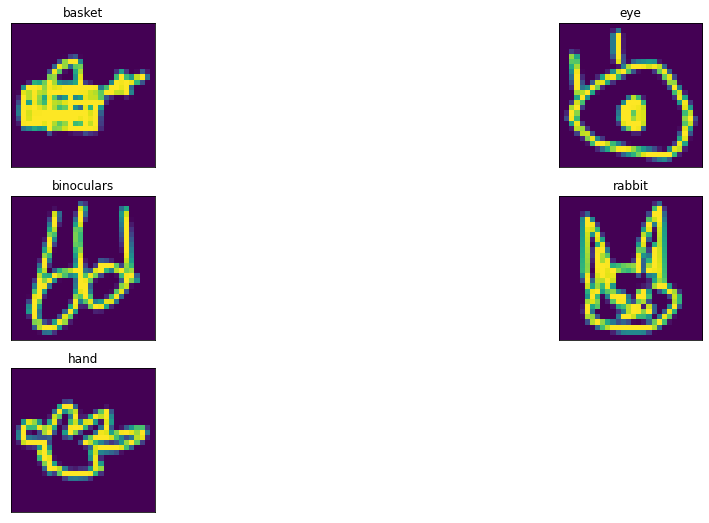

In [50]:
plt.figure(figsize=(18,9))
for i in range(0,5):
    ax= plt.subplot(3,2 ,i+1)
    mydata = pd.read_csv("train.csv",skiprows = [1], nrows=1)
    im = Image.open('images/'+classes[i]+'/'+ os.listdir("images/"+classes[i])[0])
    fig=ax.imshow(im)
    plt.title(classes[i])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
plt.show()    


In [66]:
# TODO : to_categorical
def Data():
    x_train, x_test, y_train, y_test = [], [], [], []

    for img_path in train['relative_path']:
      x_train.append(np.array(Image.open('./images/' + img_path)))
    x_train = np.array(x_train)

    for label in train['class_label']:
      y_train.append(label)
    y_train = np.array(y_train)
    # for img_path in valid['relative_path']:
    #   np.append(x_test, np.array(Image.open('./images/' + img_path)))#, axis=0)

    # for label in valid['class_label']:
    #   np.append(y_test, label)

    # x_train = x_train.reshape(x_train.shape[0], img_size, img_size, 1)/255
    # x_test = x_test.reshape(x_test.shape[0], img_size, img_size, 1)/255

    # # Conversion en matrices binaires
    # y_train = tf.keras.utils.to_categorical(y_train, num_classes)
    # y_test = tf.keras.utils.to_categorical(y_test, num_classes)

    # return ((x_train, y_train),(x_test, y_test))
    print(y_train.shape)
Data()

(75000, 1)


In [52]:
from sklearn.utils import shuffle
def load_data_generator(x, y, batch_size=batch_size):
    num_samples = x.shape[0]
    while 1:  # Loop forever so the generator never terminates
        try:
            shuffle(x)
            for i in range(0, num_samples, batch_size):
                x_data = [preprocess_image(im) for im in x[i:i+batch_size]]
                y_data = y[i:i + batch_size]
            
                # convert to numpy array since this what keras required
                yield shuffle(np.array(x_data), np.array(y_data))
        except Exception as err:
            print(err)

##Modèle 1 : Fine tuning

Dans un premier temps, nous utiliserons le transfer Learning

In [53]:
def TransferModel(input_shape,stop_freeze, pretrained_model):
    '''
    @param model is a model from tensorflow.keras.applications
    '''
    #pretrained_model = MobileNetV2(input_shape=image_shape)
    
    # On ôte la dernière couche de classification
    pretrained_model.layers.pop()   
    
    #inputs = Input(input_shape)
    #x = pretrained_model(inputs)
    # On fige tous les poids sauf ceux des stop_freeze dernières couches
    for i in range(len(pretrained_model.layers) - stop_freeze):
      pretrained_model.layers[i].trainable = False
    
    model = Sequential([pretrained_model,
                        Dense(num_classes, activation='softmax')])
    
    return model

##Entraînement du réseau

In [54]:
#Choix du modèle pré-entraîné
pretrained_model = tf.keras.applications.MobileNetV2(weights="imagenet", input_shape=(96,96,3))
pretrained_model_name = "MobileNetV2"

In [55]:
(x_train, y_train) , (x_test, y_test) = Data()

# model = TransferModel(img_shape, stop_freeze, pretrained_model)
# model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# # Callback pour la sauvegarde du meilleur modèle
# if not os.path.isdir("sauve"):
#     os.mkdir("sauve")
    
# checkpoint = ModelCheckpoint(f"sauve/{pretrained_model_name}-loss-{val_loss:.2f}-acc-{accuracy:.2f}.h5",
#                                 save_best_only=True,verbose=1)


# # TODO !!!
# train_steps_epoch = np.ceil(x_train.samples / batch_size)
# val_steps_epoch = np.ceil(x_test.samples / batch_size)

# # Entraînement
# model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size,
#                         epochs=num_epochs, verbose=1, callbacks=[checkpoint])

TypeError: ignored

In [ ]:
#Construction du meilleur modèle
model = TransferModel(input_shape=image_shape,stop_freeze=2 )
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.load_weights("sauve/MobileNetV2_flowers-loss-0.76-acc-0.94.h5") # TODO

# Evaluation du modèle
evaluation = model.evaluate(x_test, verbose=1)
print("Perte = {0:5.3f}, Précision = {1:5.3f}".format(evaluation[0], evaluation[1]))

In [ ]:
# Quelques exemples de bonne / mauvaise classification
image_batch, label_batch = next(iter(x_test))

label_batch = [classes[np.argmax(label_batch[i])] for i in range(batch_size)]
predicted_classes = model.predict(image_batch)

predicted_ids = [np.argmax(predicted_classes[i]) for i in range(batch_size)]
predicted_classes = np.array([classes[id] for id in predicted_ids])

plt.figure(figsize=(10,9))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    if predicted_classes[n] == label_batch[n]:
        color = "blue"
        title = predicted_classes[n].title()
    else:
        color = "red"
        title = f"{predicted_classes[n].title()}, correct:{label_batch[n]}"
    plt.title(title, color=color)
    plt.axis('off')
_ = plt.suptitle("Prédiction (bleu : OK, rouge : KO)")
plt.tight_layout()
plt.savefig("res.png",dpi=100)